# 1 Set Up

1.1 Import useful package

In [2]:
import numpy as np 
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [3]:
#function to plot classification map
def classification_map(X,y,classifier,X_test=None,y_test=None,h=0.01,figsize=(10,10)):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    ######################################
    ### Write your code starting from here
    cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
    cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])
# Points in a mesh of [x_min, m_max] x [y_min, y_max]
    i=0
    j=1
    x_min, x_max = X[:,i].min()-1, X[:,i].max()+1
    y_min, y_max = X[:,j].min()-1, X[:,j].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    classifier.fit(X,y)
    Z = classifier.predict(grid)
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(5,5))
    if False:
        plt.scatter(xx, yy, c=Z, cmap=cmap_light, edgecolor='none')
    else:
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light,shading='auto')
    # Plot also the training points
    plt.scatter(X[:,i], X[:,j], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification with classifier "+str(classifier))
    if not X_test is None and not y_test is None: # if test set features are provided, overlay classified labels on test set as well
        plt.scatter(X_test[:,i], X_test[:,j], c=y_test,cmap=cmap_bold,marker="x")
    ax=plt.gca()
    ax.legend(["training data","test data"],loc=0,fontsize=8)
    
    return fig

1.2 Import the dataset 

In [4]:
# Import from my github 
url = "https://raw.githubusercontent.com/onezmy/Heart-Failure/main/heart.csv"
heart  = pd.read_csv(url)

In [5]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
heart.shape

(918, 12)

In [7]:
heart.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

# 2 Data Analysis

2.1 Data split

In [8]:
# Check for NaN
heart.isnull().sum().sum()

0

No missing value

In [9]:
# Extract the respons variable
y = heart.iloc[:,-1]

# Extract the predictors
X = heart.iloc[:,:-1]

# Divide data into training and testing data (80% as training, 20% as test)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=553)
train, test = train_test_split(heart, train_size=0.8, test_size=0.2, random_state=553)

In [10]:
# Get categorical/numerical variables
cat = (X.dtypes == 'object')
cat_var = list(cat[cat].index)

num = (X.dtypes != 'object')
num_var = num_cols = list(num[num].index)+ [y.name]
num_var.remove('FastingBS')
cat_var.append('FastingBS')
print("Categorical variables:",cat_var)
print("Numerical variables:",num_var)

Categorical variables: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
Numerical variables: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']


2.2 Overall visualization

In [11]:
# View the statistics for numerical columns 
X_train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,53.494550,132.356948,201.228883,0.217984,137.490463,0.881608
std,9.351954,18.790962,108.391121,0.413158,25.281375,1.065086
min,29.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,175.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.500000,0.000000,139.000000,0.600000
75%,60.000000,140.000000,268.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,194.000000,6.200000


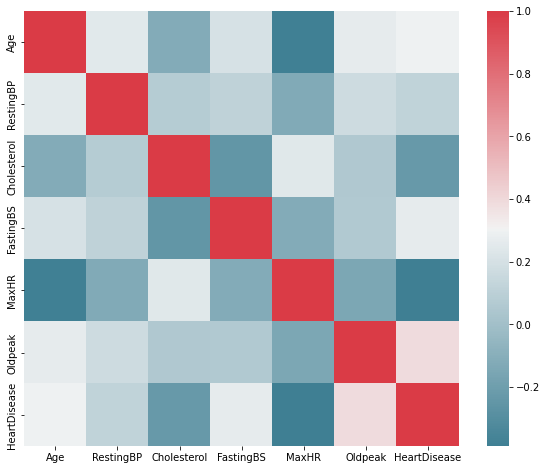

In [12]:
# Plot the correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

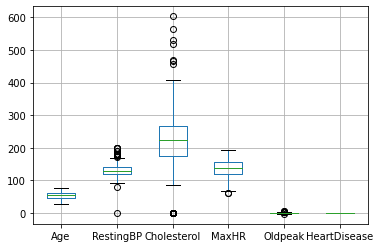

In [13]:
# View boxplot of numerical predictors 
train.boxplot(num_var)



1.   `RestingBP` should not be 0.
2.   `Cholesterol` should not be 0.



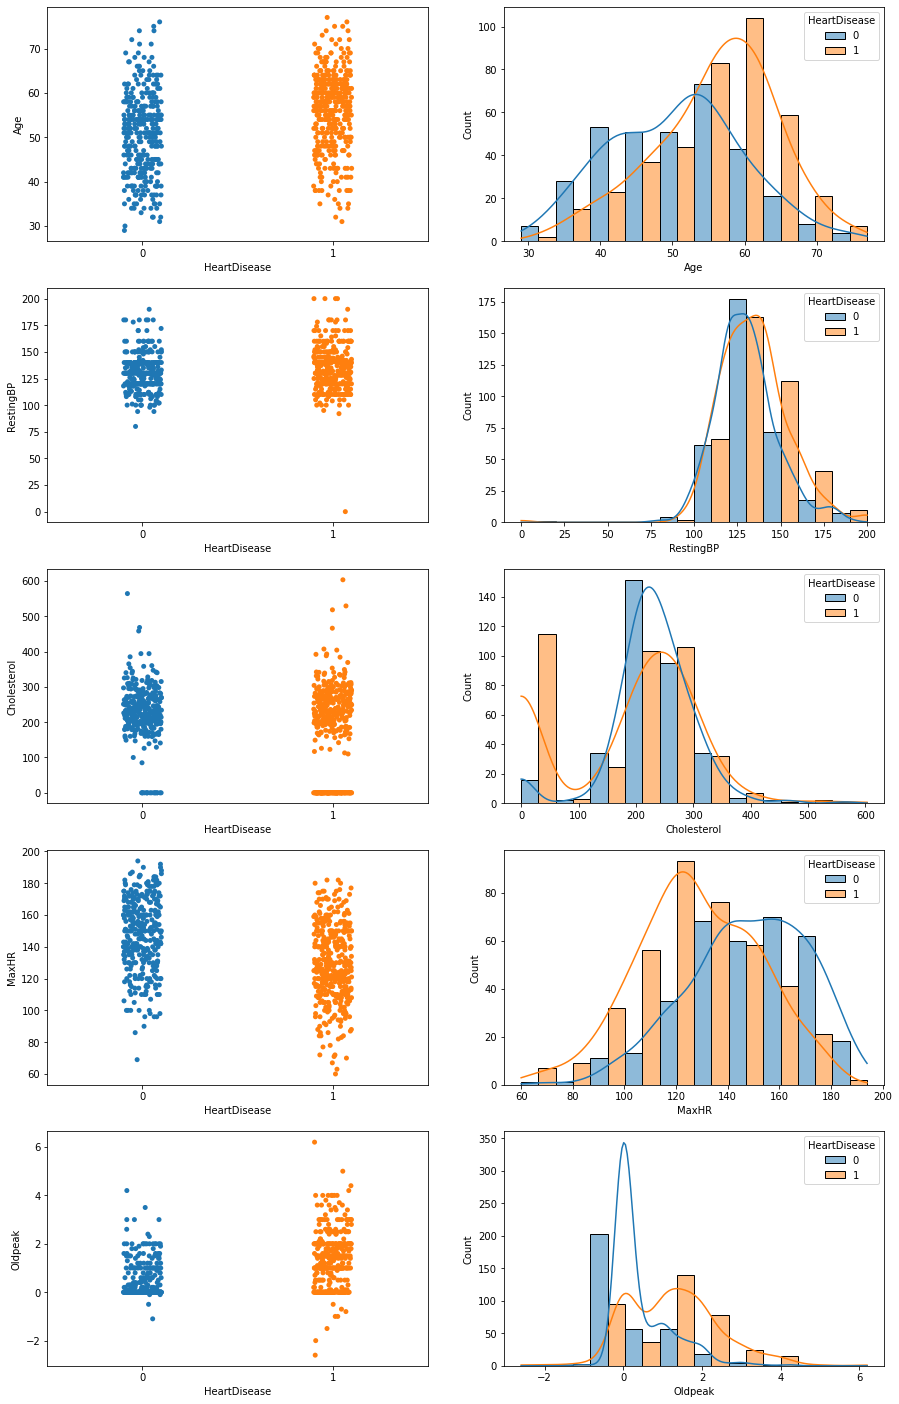

In [14]:
# View the relation between numerical predictors and response variable
fig, axes = plt.subplots(len(num_var)-1, 2, figsize=(15,25))
for i, col in zip(range(len(num_var)-1), num_var):
  # Scatter plot
  sns.stripplot(ax=axes[i][0], x='HeartDisease', y=col, data=train, jitter=True)
  # Histogram
  sns.histplot(ax=axes[i][1], x=col, data=train, kde=True, bins=10, hue='HeartDisease', multiple='dodge')

1. There are some outliers may need to be removed.
2. When `Cholesterol` = 0, there is an unusual high frequency of heart disease. 

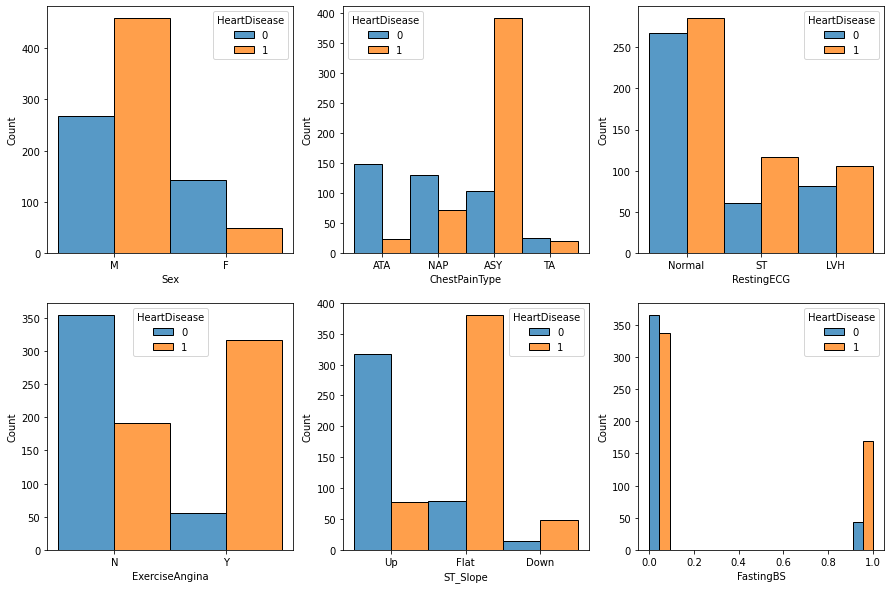

In [15]:
# View the relation between catagorical predictors and response variable
fig, axes = plt.subplots(len(cat_var)//3, 3, figsize=(15,10))
for i, col in zip(range(len(cat_var)), cat_var):
  # Histogram
  sns.histplot(ax=axes[i//3][i%3], x=col, data=heart, hue='HeartDisease', multiple='dodge', bins='auto')

2.3 Data Preprocess

In [16]:
# Make up the incorrect 0s in `RestingBP` with median
heart.loc[heart['RestingBP'] ==0,'RestingBP']  = heart['RestingBP'].median()

# Make up the incorrect 0s in `Cholesterol` with median
heart.loc[heart['Cholesterol'] ==0,'Cholesterol']  = heart['Cholesterol'].median()

In [17]:
# Remove 'Cholesterol' Column

heart.drop('Cholesterol', axis=1, inplace=True)
num_var.remove('Cholesterol')


In [18]:
# Remove numerical outliers with the boundary values

for var in heart[num_var].columns:
  q1 = heart[var].quantile(0.25)
  q3 = heart[var].quantile(0.75)
  inner_range = q3 - q1
  upper_bound = q3 + 1.5 * inner_range
  lower_bound = q1 - 1.5 * inner_range
  heart.loc[(heart[var] < lower_bound), var] = lower_bound
  heart.loc[(heart[var] > upper_bound), var] = upper_bound

In [19]:
# Convert all catagorical predictors into numerical labeling
LE = LabelEncoder()
object_cols= cat_var
for i in object_cols:
    heart[i]=heart[[i]].apply(LE.fit_transform)
heart[cat_var].head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope,FastingBS
0,1,1,1,0,2,0
1,0,2,1,0,1,0
2,1,1,2,0,2,0
3,0,0,1,1,1,0
4,1,2,1,0,2,0


In [20]:
# Update the training and test set again

# Extract the respons variable
y = heart.iloc[:,-1]

# Extract the predictors
X = heart.iloc[:,:-1]

# Divide data into training and testing data (80% as training, 20% as test)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=553)
train, test = train_test_split(heart, train_size=0.8, test_size=0.2, random_state=553)

# Divide data into training and testing data (50% as training, 50% as test)
X_train_half, X_test_half, y_train_half, y_test_half = train_test_split(X, y, train_size=0.5, test_size=0.5, random_state=553)

In [ ]:
#Approach to deal with cholesterol column
'''
# first step replace zeros with NaN
X_train['Cholesterol'] = X_train['Cholesterol'].replace([0],np.nan)
X_test['Cholesterol'] = X_test['Cholesterol'].replace([0],np.nan)

# second step use KNNImputer with numerical columns to interpolate nan values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_train[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']]=imputer.fit_transform(X_train[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']])
X_test[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']]=imputer.transform(X_test[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']]) 
'''

'\n# first step replace zeros with NaN\nX_train[\'Cholesterol\'] = X_train[\'Cholesterol\'].replace([0],np.nan)\nX_test[\'Cholesterol\'] = X_test[\'Cholesterol\'].replace([0],np.nan)\n\n# second step use KNNImputer with numerical columns to interpolate nan values\nfrom sklearn.impute import KNNImputer\nimputer = KNNImputer(n_neighbors=2, weights="uniform")\nX_train[[\'Age\', \'RestingBP\', \'Cholesterol\', \'FastingBS\', \'MaxHR\', \'Oldpeak\']]=imputer.fit_transform(X_train[[\'Age\', \'RestingBP\', \'Cholesterol\', \'FastingBS\', \'MaxHR\', \'Oldpeak\']])\nX_test[[\'Age\', \'RestingBP\', \'Cholesterol\', \'FastingBS\', \'MaxHR\', \'Oldpeak\']]=imputer.transform(X_test[[\'Age\', \'RestingBP\', \'Cholesterol\', \'FastingBS\', \'MaxHR\', \'Oldpeak\']]) \n'

In [21]:
X_train

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
242,55.0,1,1,160.0,1,1,143.0,1,2.0,1
782,53.0,1,2,130.0,1,0,152.0,0,1.2,0
517,65.0,1,0,150.0,0,1,120.0,1,1.5,1
326,45.0,1,2,110.0,0,1,138.0,0,-0.1,2
555,58.0,1,2,150.0,0,2,118.0,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...
71,44.0,1,1,130.0,0,1,135.0,0,0.0,2
122,46.0,1,0,110.0,0,2,140.0,0,0.0,2
47,50.0,1,1,140.0,0,1,170.0,0,0.0,2
901,58.0,0,0,170.0,1,0,146.0,1,2.8,1


# 3 Modeling 

3.1 Logistics Regression

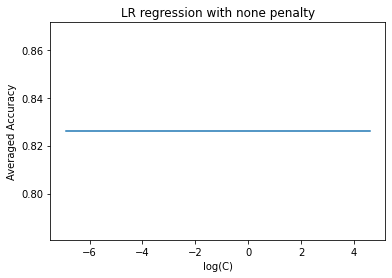

The optimal C is 0.001 , with accuracy 0.8260869565217391

 ---------------------------------------------------------- 



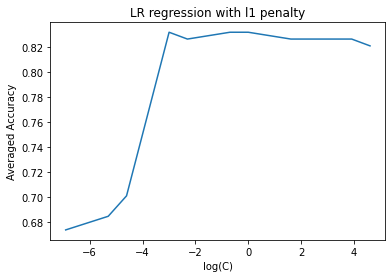

The optimal C is 0.05 , with accuracy 0.8315217391304348

 ---------------------------------------------------------- 



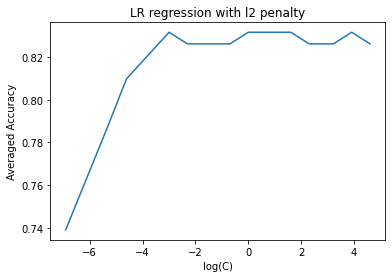

The optimal C is 0.05 , with accuracy 0.8315217391304348

 ---------------------------------------------------------- 



In [24]:

C = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100]
lr_scores = [0]*len(C) # List for storing the averaged accuracies.

for p in ['none','l1','l2']:
  for i in range(len(C)):
    # Get the current c
    c = C[i]

    # Initialize the LR model 
    if p == 'l1':
      lr_clf = LogisticRegression(C=c, penalty=p, max_iter=5000,solver='liblinear')
    else:
      lr_clf = LogisticRegression(C=c, penalty=p, max_iter=5000)
    
    # Fit model with training data
    lr_clf.fit(X_train,y_train)

    # Make prediction of the testing data
    y_pred = lr_clf.predict(X_test)

    # Compute the prediction accuracy
    lr_acc = accuracy_score(y_test, y_pred)
    lr_scores[i] = lr_acc
    
  plt.plot(np.log(C), lr_scores)
  plt.xlabel("log(C)")
  plt.ylabel("Averaged Accuracy")
  plt.title("LR regression with "+ p +" penalty")
  plt.show()
  print("The optimal C is", C[lr_scores.index(max(lr_scores))],", with accuracy",max(lr_scores))
  print("\n ---------------------------------------------------------- \n")

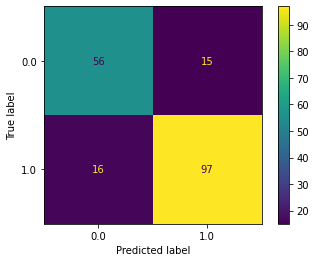

In [25]:
# View the best confusion matrix
lr_clf = LogisticRegression(C=0.05, penalty='l2', max_iter=10000)
lr_clf.fit(X_train,y_train)
plot_confusion_matrix(lr_clf, X_test, y_test)


3.2 Desicion Tree

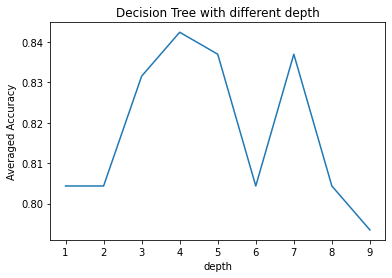

The best depth is 3 , when accuracy = 0.842391304347826


In [ ]:
score = []
for depth in range(1,10):
    dt_clf = tree.DecisionTreeClassifier(max_depth=depth)
    dt_clf.fit(X_train,y_train)
    score.append(dt_clf.score(X_test,y_test))
plt.plot(range(1,10),score)
plt.xlabel("depth")
plt.ylabel("Averaged Accuracy")
plt.title("Decision Tree with different depth")
plt.show()
print("The best depth is",score.index(np.max(score)) ,", when accuracy =", np.max(score))

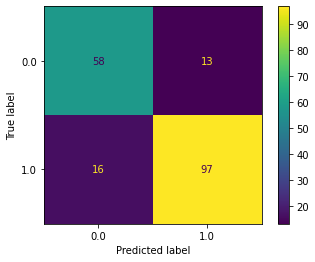

In [ ]:
dt_clf = tree.DecisionTreeClassifier(max_depth=4)
dt_clf.fit(X_train,y_train)
plot_confusion_matrix(dt_clf, X_test, y_test)

3.3 Random Forest

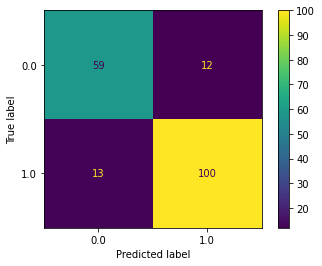

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200,max_depth=4)
z = rf_clf.fit(X_train,y_train)
y_pred = z.predict(X_test)
plot_confusion_matrix(rf_clf, X_test, y_test)

In [ ]:
print("The accuracy is ", accuracy_score(y_test,y_pred))
importances = pd.DataFrame(rf_clf.feature_importances_, index=X_train.columns, columns=["Importance"])
importances.sort_values(by = 'Importance', inplace=True, ascending=False)
cum_importance = []
total = 0
for i in range(len(np.array(importances))):
  cum_importance.append(sum(np.array(importances)[:i+1])[0])
cum_importance
importances['Cum_Importance'] = cum_importance
importances

The accuracy is  0.8641304347826086


,Importance,Cum_Importance
ST_Slope,0.361255,0.361255
ChestPainType,0.193840,0.555095
ExerciseAngina,0.136609,0.691704
Oldpeak,0.105902,0.797606
MaxHR,0.056549,0.854155
Sex,0.045403,0.899557
Age,0.043143,0.942700
FastingBS,0.026371,0.969071
RestingBP,0.023133,0.992204
RestingECG,0.007796,1.000000


Choose the first 6 features, which explain more than 90% variance reduction in total.

3.4 Naive Bayes,LDA and QDA

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("The accuracy rate of Gaussian Naive Bayes Classifier is: ",accuracy_score(y_test,y_pred))

The accuracy rate of Gaussian Naive Bayes Classifier is:  0.8315217391304348


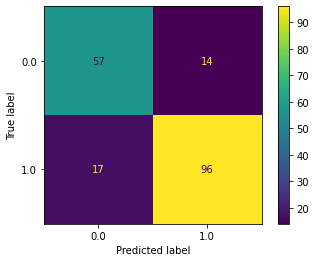

In [ ]:
plot_confusion_matrix(gnb, X_test, y_test)

In [ ]:
# with scaled features
gnb = GaussianNB()
scaler = StandardScaler()
X_new_train = scaler.fit_transform(X=X_train)
X_new_test= scaler.transform(X=X_test)
y_pred = gnb.fit(X_new_train, y_train).predict(X_new_test)
print("The accuracy rate of Gaussian Naive Bayes Classifier is: ",accuracy_score(y_test,y_pred))

The accuracy rate of Gaussian Naive Bayes Classifier is:  0.8315217391304348


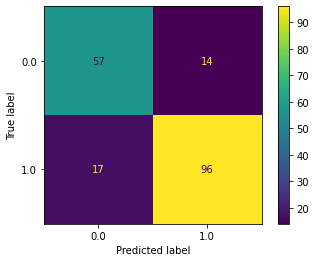

In [ ]:
plot_confusion_matrix(gnb, X_new_test, y_test)

Gaussian Naive Bayes with two most important numerical features- 'Oldpeak' and 'MaxHR'
The accuracy rate of two feature Gaussian Naive Bayes is:  0.7663043478260869


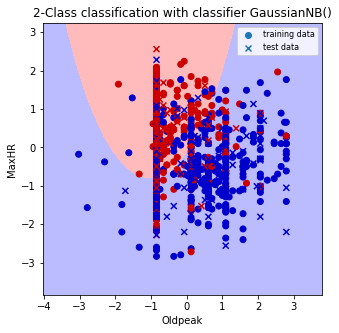

In [ ]:
features=list(X_train.columns)
featuresxy=[8,6]
classification_map(X_new_train[:,featuresxy],y_train,gnb,X_test=X_new_test[:,featuresxy],y_test=y_test)
plt.xlabel(features[featuresxy[0]])
plt.ylabel(features[featuresxy[1]])
print("Gaussian Naive Bayes with two most important numerical features- \'Oldpeak\' and \'MaxHR\'")
gnb = GaussianNB()
gnb.fit(X_new_train[:,featuresxy], y_train)
y_pred = gnb.predict(X_new_test[:,featuresxy])
print("The accuracy rate of two feature Gaussian Naive Bayes is: ",accuracy_score(y_test,y_pred))
plt.show()

In [ ]:
#using scaled features
scaler = StandardScaler()
X_new_train = scaler.fit_transform(X=X_train)
X_new_test= scaler.transform(X=X_test)
LDA_model = LDA()
LDA_model.fit(X_new_train, y_train)
# predict target
y_pred = LDA_model.predict(X_new_test)
print("The accuracy rate of Linear Discriminant Classifier is: ",accuracy_score(y_test,y_pred))

The accuracy rate of Linear Discriminant Classifier is:  0.8369565217391305


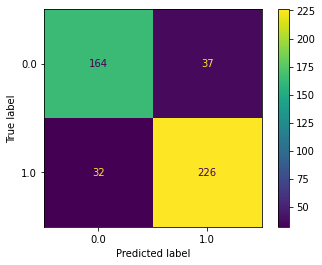

In [ ]:
plot_confusion_matrix(LDA_model, X_new_test, y_test)

LDA with two most important quantitative features- 'Oldpeak' and 'MaxHR'
The accuracy rate of two feature LDA is:  0.7516339869281046


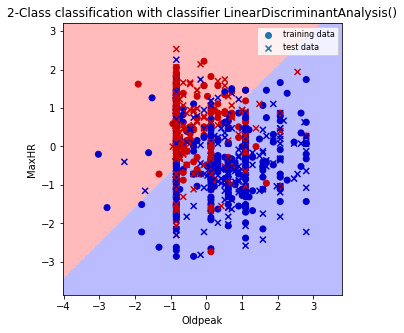

In [ ]:
features=list(X_train.columns)
featuresxy=[8,6]
classification_map(X_new_train[:,featuresxy],y_train,LDA_model,X_test=X_new_test[:,featuresxy],y_test=y_test)
plt.xlabel(features[featuresxy[0]])
plt.ylabel(features[featuresxy[1]])
print("LDA with two most important quantitative features- \'Oldpeak\' and \'MaxHR\'")
LDA_model.fit(X_new_train[:,featuresxy], y_train)
y_pred = LDA_model.predict(X_new_test[:,featuresxy])
print("The accuracy rate of two feature LDA is: ",accuracy_score(y_test,y_pred))
plt.show()

In [ ]:
#using scaled features
scaler = StandardScaler()
X_new_train=X_train[:]
X_new_test=X_test[:]
X_new_train = scaler.fit_transform(X=X_new_train)
X_new_test= scaler.transform(X=X_new_test)
QDA_model = QDA()
QDA_model.fit(X_new_train, y_train)
# predict target
y_pred = QDA_model.predict(X_new_test)
print("The accuracy rate of Quadratic Discriminant Classifier is: ",accuracy_score(y_test,y_pred))

The accuracy rate of Quadratic Discriminant Classifier is:  0.8152173913043478


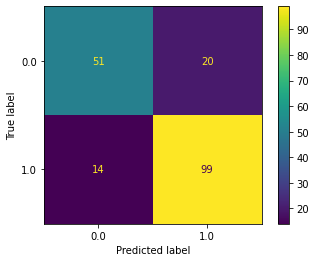

In [ ]:
plot_confusion_matrix(QDA_model, X_new_test, y_test)

QDA with two most important numerical features- 'Oldpeak' and 'MaxHR'
The accuracy rate of two feature QDA is:  0.7663043478260869


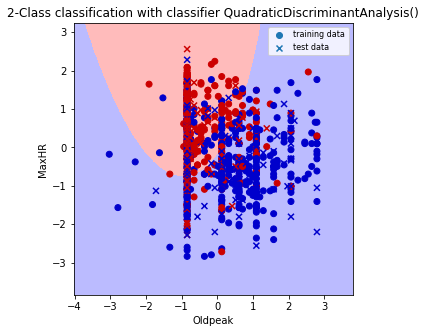

In [ ]:

featuresxy=[8,6]
classification_map(X_new_train[:,featuresxy],y_train,QDA_model,X_test=X_new_test[:,featuresxy],y_test=y_test)
plt.xlabel(features[featuresxy[0]])
plt.ylabel(features[featuresxy[1]])
print("QDA with two most important numerical features- \'Oldpeak\' and \'MaxHR\'")
QDA_model.fit(X_new_train[:,featuresxy], y_train)
y_pred = QDA_model.predict(X_new_test[:,featuresxy])
print("The accuracy rate of two feature QDA is: ",accuracy_score(y_test,y_pred))
plt.show()

3.5 SVM

In [ ]:
C_lst = [0.001,0.01,0.1,1,10,100,1000]
ker_lst = ['linear','rbf']
gamma_lst=[0.0001,0.001,0.01,0.1]


#normalize features
scaler = StandardScaler()
X_new_train = scaler.fit_transform(X=X_train)
X_new_test= scaler.transform(X=X_test)

SVM_score = [0]
param=[0,0,0]
# Fit in the model with selected parameters
for C in C_lst:
    for gamma in gamma_lst:
        for ker in ker_lst:
            svm = SVC(kernel=ker, C=C, gamma=gamma)
            svm.fit(X_new_train,y_train)
            y_pred = svm.predict(X_new_test)
            score = np.mean(cross_val_score(svm, X_new_train, y_train, cv=10))
            print(ker,gamma,C,score)
            if score > max(SVM_score):
              param = [ker,gamma,C]
            SVM_score.append(score)  
print("The best prediction score is ",max(SVM_score) ,", when (kernel,gamma,C) =", param)

linear 0.0001 0.001 0.8336542021473529
rbf 0.0001 0.001 0.5381340244353943
linear 0.001 0.001 0.8336542021473529
rbf 0.001 0.001 0.5381340244353943
linear 0.01 0.001 0.8336542021473529
rbf 0.01 0.001 0.5381340244353943
linear 0.1 0.001 0.8336542021473529
rbf 0.1 0.001 0.5381340244353943
linear 0.0001 0.01 0.8486856719733431
rbf 0.0001 0.01 0.5381340244353943
linear 0.001 0.01 0.8486856719733431
rbf 0.001 0.01 0.5381340244353943
linear 0.01 0.01 0.8486856719733431
rbf 0.01 0.01 0.5381340244353943
linear 0.1 0.01 0.8486856719733431
rbf 0.1 0.01 0.6076823398741207
linear 0.0001 0.1 0.8541466123657904
rbf 0.0001 0.1 0.5381340244353943
linear 0.001 0.1 0.8541466123657904
rbf 0.001 0.1 0.5381340244353943
linear 0.01 0.1 0.8541466123657904
rbf 0.01 0.1 0.8377823028507961
linear 0.1 0.1 0.8541466123657904
rbf 0.1 0.1 0.8432802665679378
linear 0.0001 1 0.8541466123657905
rbf 0.0001 1 0.5381340244353943
linear 0.001 1 0.8541466123657905
rbf 0.001 1 0.8391336542021474
linear 0.01 1 0.854146612365

The accuracy rate of the SVM classifier (C=1, gamma=0.1) = 0.875


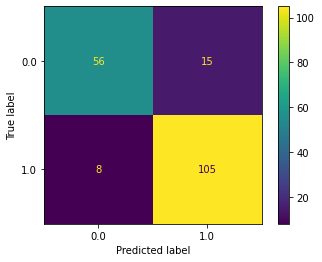

In [ ]:
svm = SVC(kernel='rbf', C=1, gamma=0.1)
svm.fit(X_new_train,y_train)
y_pred = svm.predict(X_new_test)
print("The accuracy rate of the SVM classifier (C=1, gamma=0.1) =",accuracy_score(y_test,y_pred))
plot_confusion_matrix(svm, X_new_test, y_test)

SVM classifier with two most imporant numerical features- 'Oldpeak' and 'MaxHR'
The accuracy rate of two feature SVM classifier is:  0.7717391304347826


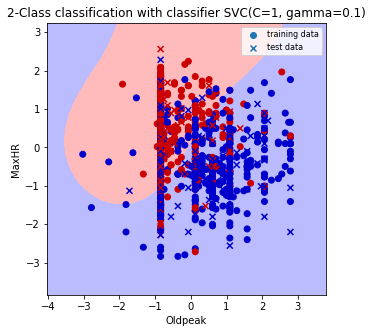

In [ ]:
features=list(X_train.columns)
featuresxy=[8,6]
classification_map(X_new_train[:,featuresxy],y_train,svm,X_test=X_new_test[:,featuresxy],y_test=y_test)
plt.xlabel(features[featuresxy[0]])
plt.ylabel(features[featuresxy[1]])
print("SVM classifier with two most imporant numerical features- \'Oldpeak\' and \'MaxHR\'")
svm = SVC(kernel='rbf', C=1, gamma=0.1)
svm.fit(X_new_train[:,featuresxy],y_train)
y_pred = svm.predict(X_new_test[:,featuresxy])
print("The accuracy rate of two feature SVM classifier is: ",accuracy_score(y_test,y_pred))
plt.show()

3.6 K-NN

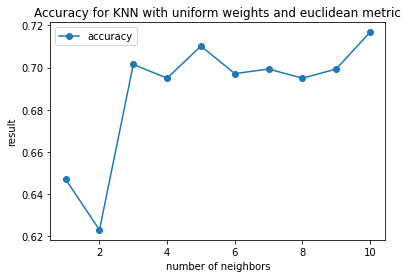

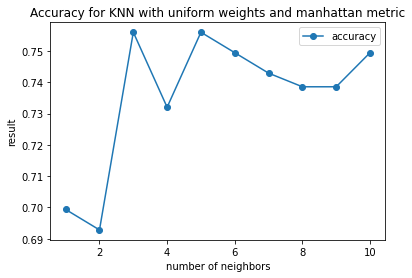

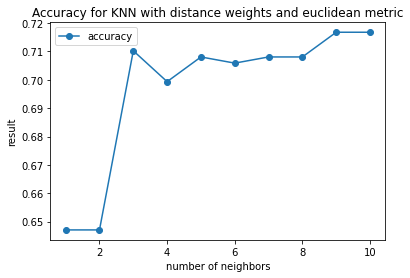

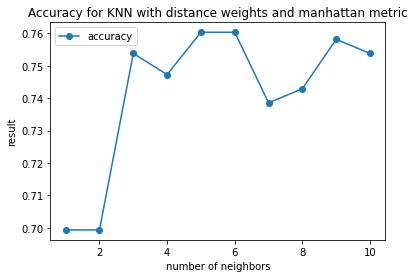

The when accuracy = 0.7603485838779956 with (n_neighbors,weights,metrix)= (5, 'distance', 'manhattan')


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
neighbors = [1,2,3,4,5,6,7,8,9,10]
weights = ['uniform', 'distance']
metric =  ['euclidean', 'manhattan']
max_score = 0
for j in weights:
  for k in metric:
    knn_score_lst = []
    for i in neighbors:
        knn_model = KNeighborsClassifier(n_neighbors=i,weights=j,metric=k)
        knn_model.fit(X_train[features], y_train)
        preds = knn_model.predict(X_test[features])
        accuracy = accuracy_score(preds,y_test)
        mse = mean_squared_error(preds,y_test)
        knn_score_lst.append(accuracy)
        if max_score < accuracy:
          max_score = accuracy
          param = (i,j,k)
    # generate a plot with above result
    plt.plot(neighbors, knn_score_lst, "-o", label = "accuracy")
    plt.xlabel('number of neighbors')
    # Set the y axis label of the current axis.
    plt.ylabel('result')
    # Set a title of the current axes.
    plt.title('Accuracy for KNN with '+str(j)+' weights and '+ k+' metric')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()

print("The when accuracy =", max_score,"with (n_neighbors,weights,metrix)=",param)

 3.7 Neural Networks

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [ ]:
# list all parameters
param_lst  = {}


# All selection of the parameters
############ Run the whole list will take around 50 mins ###################
param_lst['batch_size']=[30, 60, 90]
param_lst['activation'] = ['relu', 'tanh', 'sigmoid']
param_lst['kernel_initializer'] = ['HeNormal', 'GlorotNormal']
param_lst['neurons'] = [8,9,10]
param_lst['epochs'] = [500]
param_lst['learning_rate'] = [0.001, 0.01]
"""

# Best nn model parameters
param_lst['batch_size']=[60]
param_lst['activation'] = ['relu']
param_lst['kernel_initializer'] = ['HeNormal']
param_lst['neurons'] = [9]
param_lst['epochs'] = [500]
param_lst['learning_rate'] = [0.01]
"""

# Initializer
def create_network(learning_rate=0.01, activation='tanh', kernel_initializer='HeNormal', neurons=9):
  model = Sequential()
  model.add(Dense(neurons, input_dim=10, kernel_initializer=kernel_initializer, activation=activation))
  model.add(Dense(1, activation='sigmoid'))
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])
  return model

network = KerasClassifier(build_fn=create_network, epochs=500, verbose=2)
nn_model = GridSearchCV(network, param_lst, cv=KFold(n_splits=2), n_jobs=1, verbose=1, return_train_score=True, scoring='accuracy', refit=True)
nn_model.fit(X_new_train, y_train)
print('The best parameters are:', nn_model.best_params_)
print('The best score that we got is:' ,nn_model.best_score_)

y_pred = nn_model.predict(X_new_test)
score=accuracy_score(y_pred,y_test)
print("The associate accuracy rate on test set is ",score)

流式输出内容被截断，只能显示最后 5000 行内容。
5/5 - 0s - loss: 0.6066 - binary_accuracy: 0.7847 - 12ms/epoch - 2ms/step
Epoch 3/500
5/5 - 0s - loss: 0.5642 - binary_accuracy: 0.8174 - 15ms/epoch - 3ms/step
Epoch 4/500
5/5 - 0s - loss: 0.5298 - binary_accuracy: 0.8311 - 12ms/epoch - 2ms/step
Epoch 5/500
5/5 - 0s - loss: 0.5004 - binary_accuracy: 0.8338 - 11ms/epoch - 2ms/step
Epoch 6/500
5/5 - 0s - loss: 0.4755 - binary_accuracy: 0.8338 - 11ms/epoch - 2ms/step
Epoch 7/500
5/5 - 0s - loss: 0.4550 - binary_accuracy: 0.8338 - 10ms/epoch - 2ms/step
Epoch 8/500
5/5 - 0s - loss: 0.4371 - binary_accuracy: 0.8283 - 10ms/epoch - 2ms/step
Epoch 9/500
5/5 - 0s - loss: 0.4231 - binary_accuracy: 0.8256 - 10ms/epoch - 2ms/step
Epoch 10/500
5/5 - 0s - loss: 0.4117 - binary_accuracy: 0.8283 - 10ms/epoch - 2ms/step
Epoch 11/500
5/5 - 0s - loss: 0.4015 - binary_accuracy: 0.8311 - 10ms/epoch - 2ms/step
Epoch 12/500
5/5 - 0s - loss: 0.3947 - binary_accuracy: 0.8311 - 9ms/epoch - 2ms/step
Epoch 13/500
5/5 - 0s - loss: 0.3894 